In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms
from morphology import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE

# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

import tensorflow as tf

img_path = 'catdog.png'
img = read_tensor(img_path)
img_insertion = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=243):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()

    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities

    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')

print(predicted_classes)
get_class_name(top_classes[0].item())
target_class = top_classes[0].item()
print(get_class_name(target_class))

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Prediction for class 243 = 38.42%
Top 1 class: bull mastiff, Probability: 38.42%
Top 2 class: tiger cat, Probability: 16.83%
Top 3 class: boxer, Probability: 9.41%
Prediction for class 243 = 38.42%
bull mastiff


Generating filters: 100%|██████████| 10/10 [00:00<00:00, 130.08it/s]


interactive(children=(IntSlider(value=0, description='Mask Index:', max=9), Output()), _dom_classes=('widget-i…

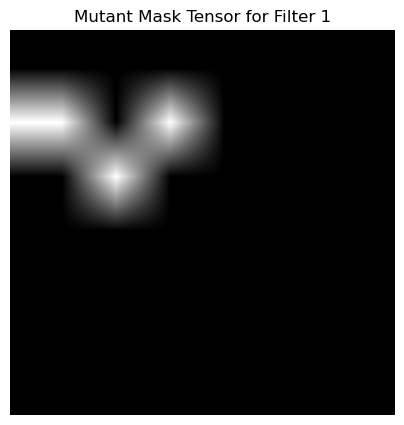

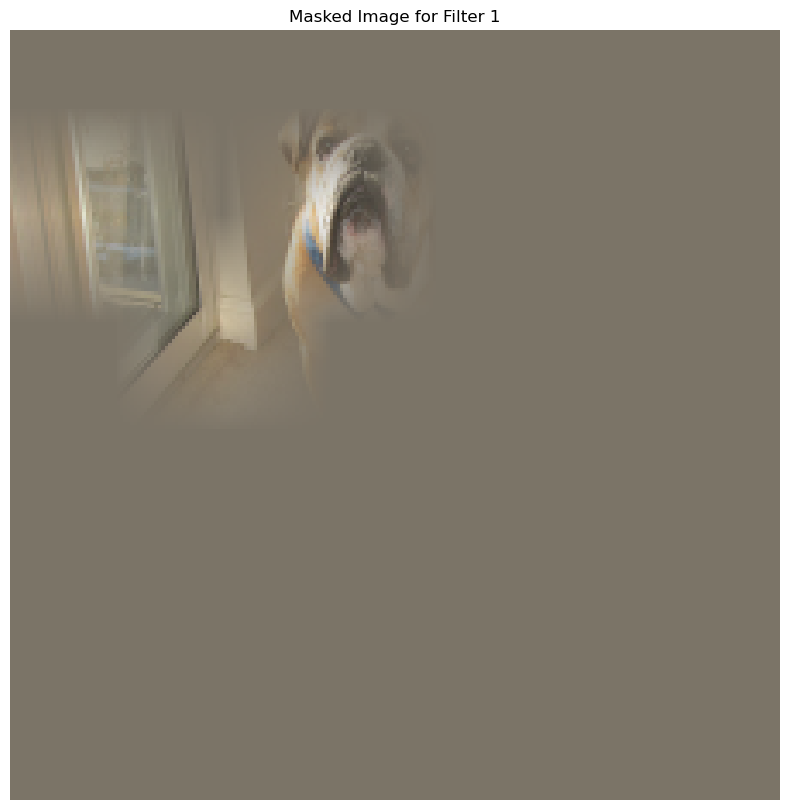

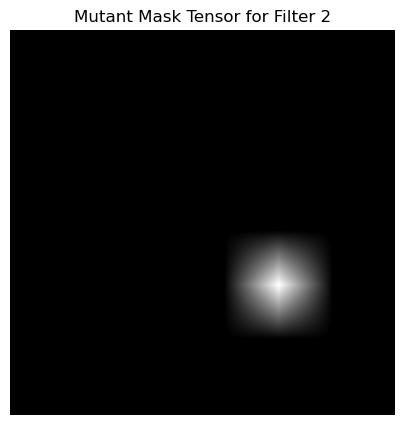

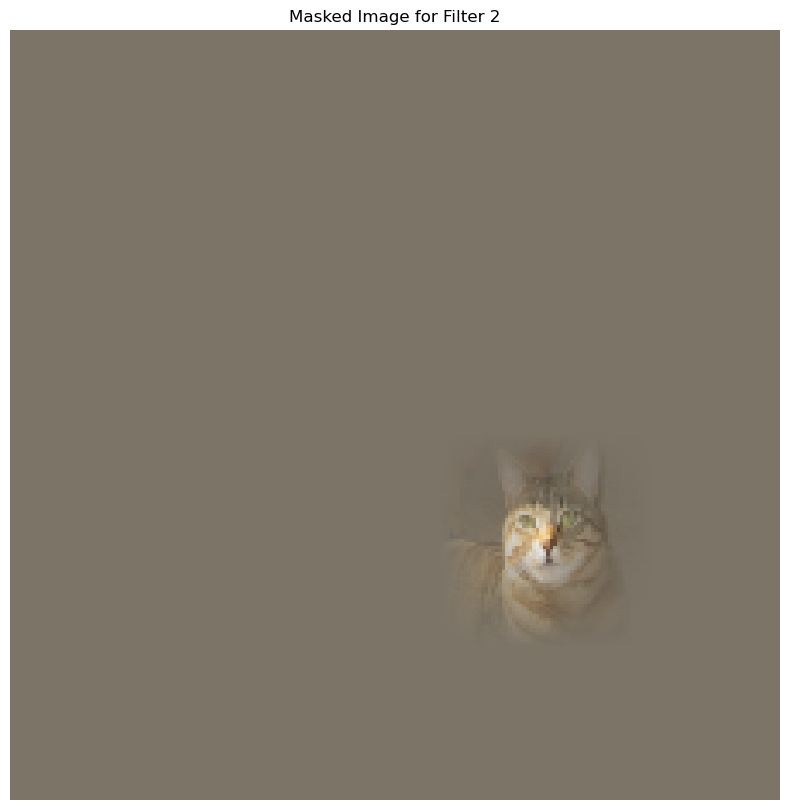

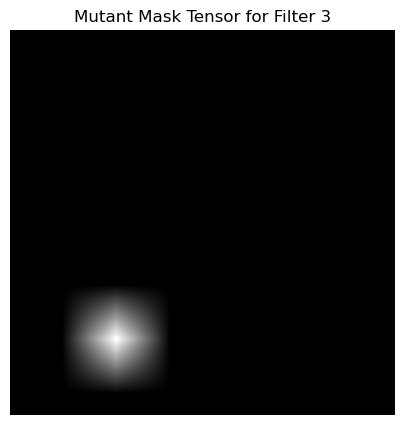

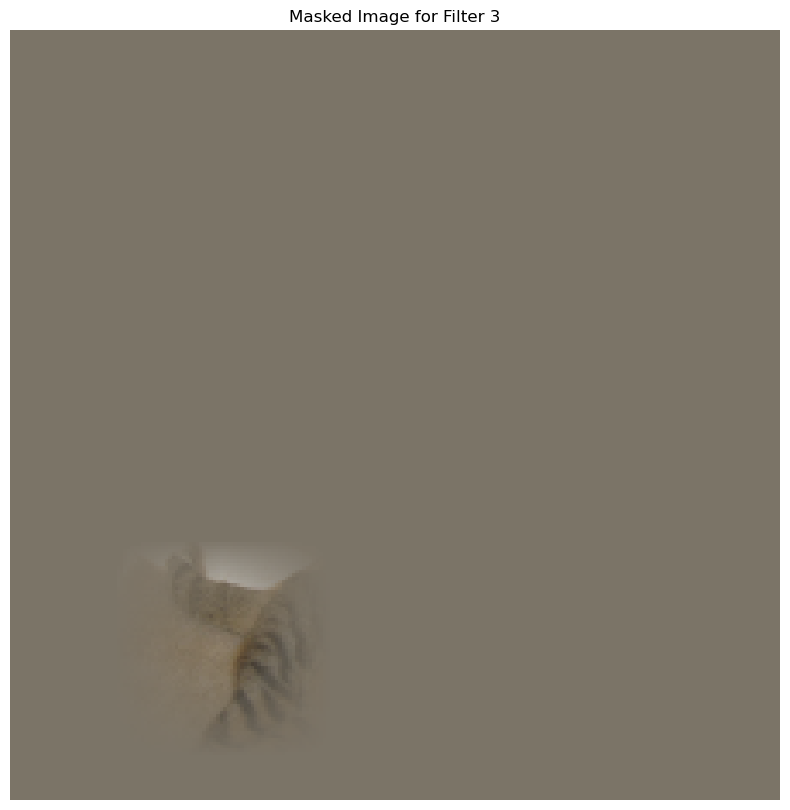

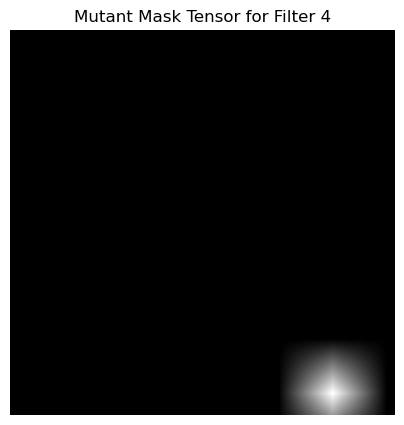

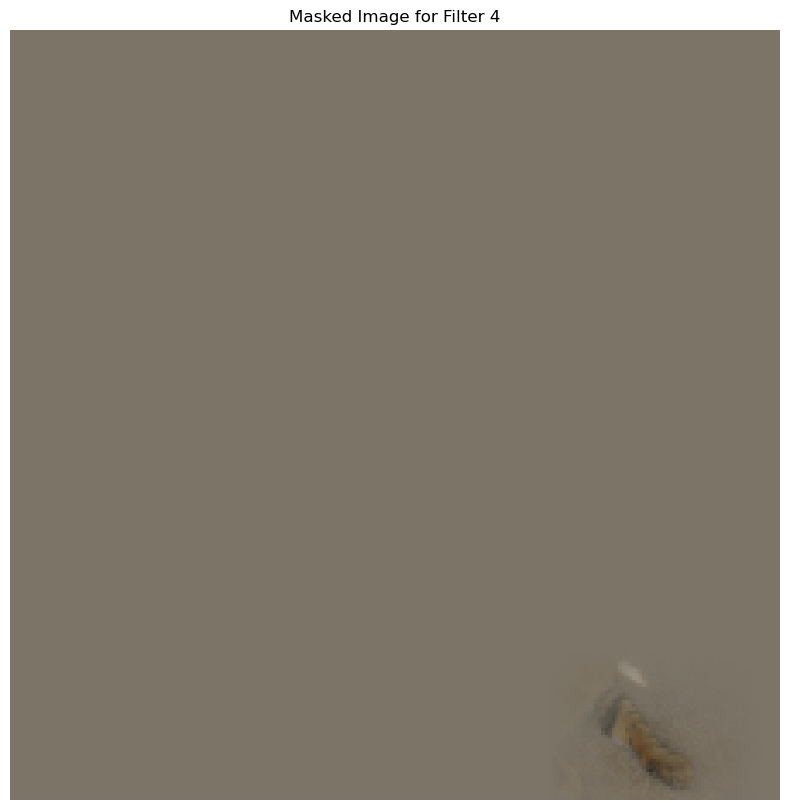

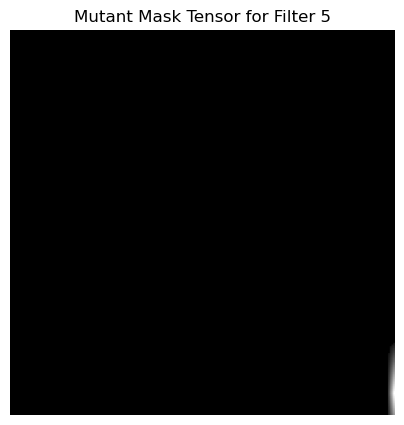

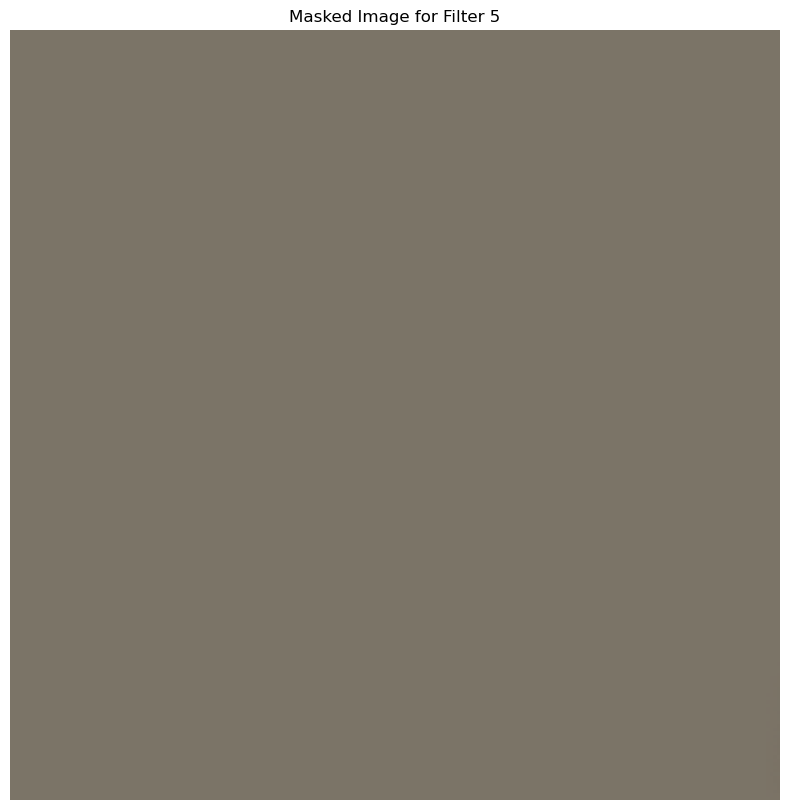

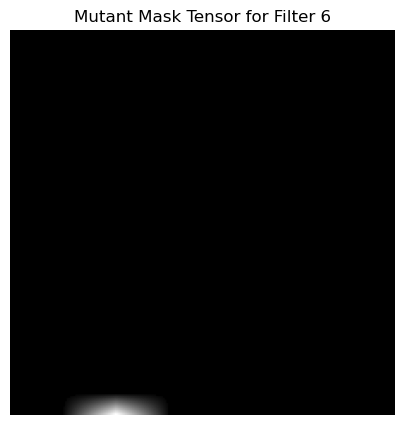

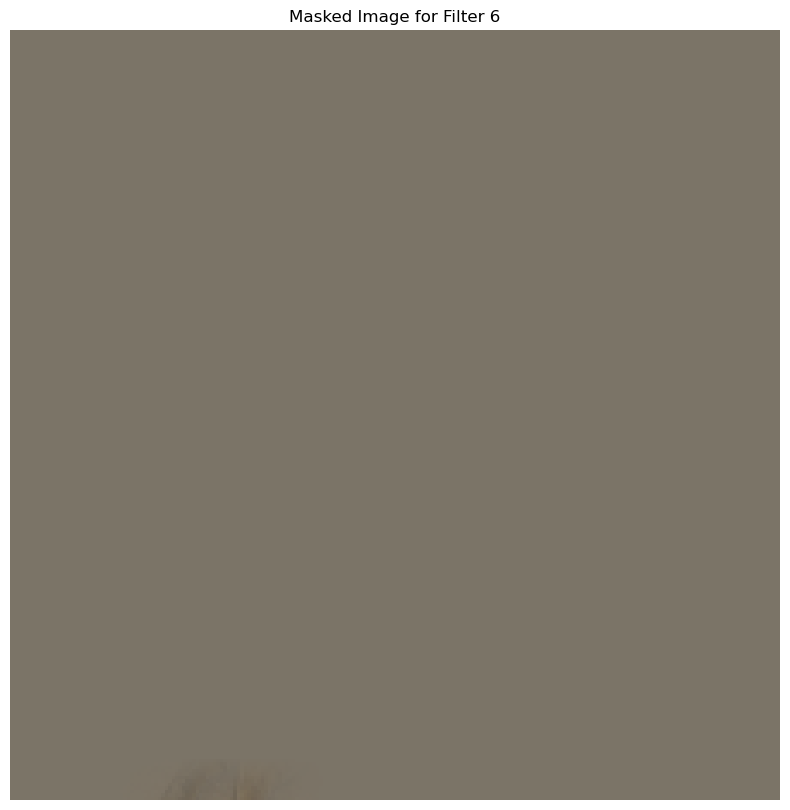

Retained only the most relevant filter 0 in mask 0


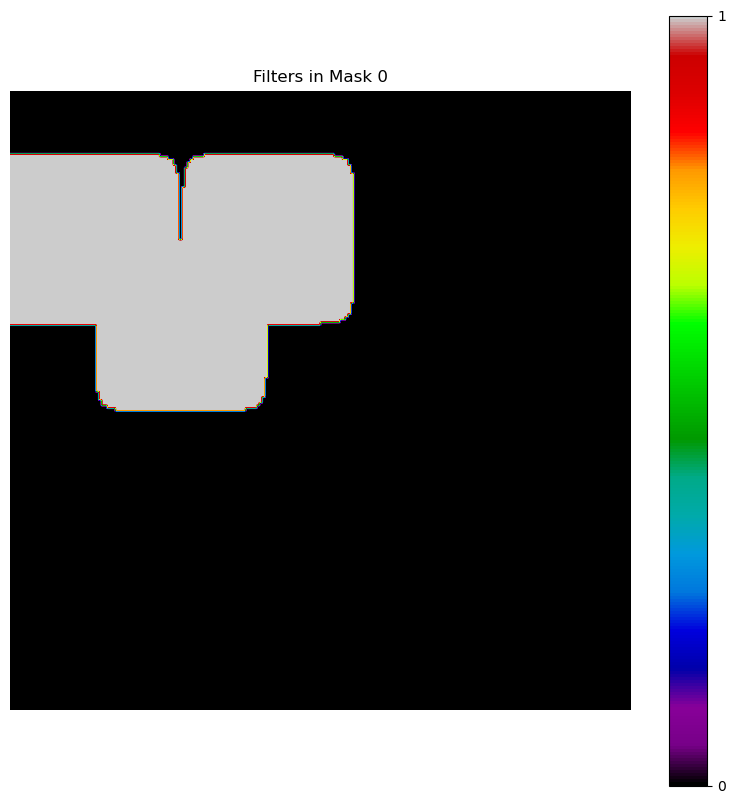

Number of filters: 1


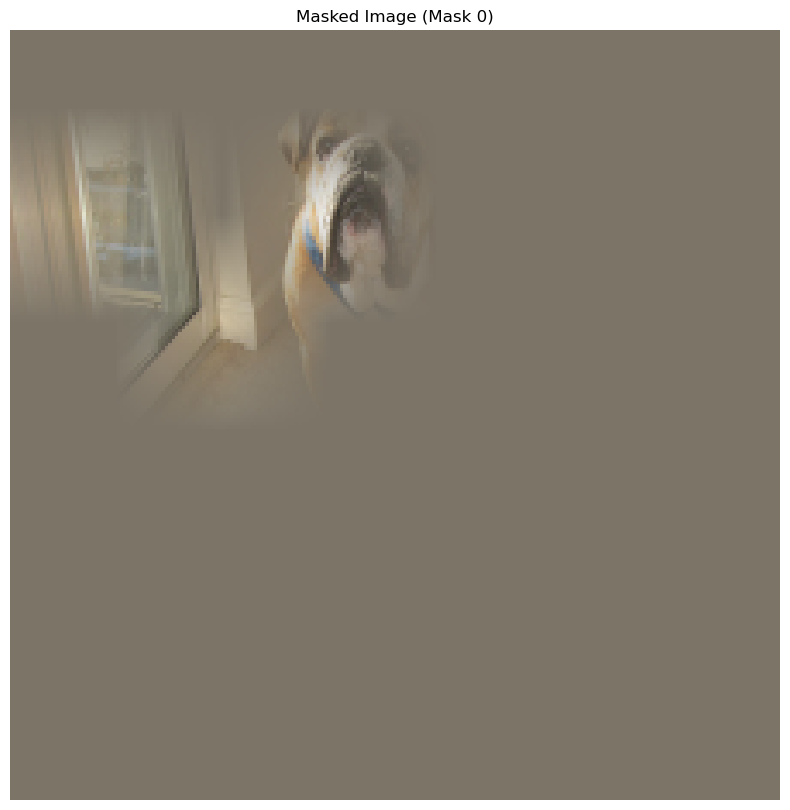

In [46]:
#POR FAVOR NO EDITES ESTE CÓDIGO
from scipy.ndimage import binary_dilation
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from skimage.transform import resize
from tqdm import tqdm
from morphology import Dilation2d, Erosion2d
import cv2
from skimage.measure import label
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))
        self.filters = []

        # Assuming F is the number of filters in each grid
        F = np.sum(grid, axis=(1, 2)).astype(int).max()
        self.filter_tensor = np.zeros((N, F, 1, *self.input_size), dtype=np.float32)

        for i in tqdm(range(N), desc='Generating filters'):
            filter_count = 0
            for j in range(s):
                for k in range(s):
                    if grid[i, j, k]:
                        x = np.random.randint(0, cell_size[0])
                        y = np.random.randint(0, cell_size[1])
                        resized_filter = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
                        selected_filter = resized_filter[x:x + self.input_size[0], y:y + self.input_size[1]]
                        self.masks[i, :, :] = selected_filter
                        self.filters.append(selected_filter)
                        self.filter_tensor[i, filter_count, 0, :, :] = selected_filter
                        filter_count += 1

        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.filter_tensor = torch.from_numpy(self.filter_tensor).float().cuda()
        self.N = N
        self.p1 = p1
        return self.masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def count_filters_in_mask(self, mask):
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        if mask.ndim == 3:
            mask = mask[0]
        
        num_filters = 0
        for i in range(self.filter_tensor.shape[1]):
            filter_match = np.allclose(mask, self.filter_tensor[0, i, 0, :, :].cpu().numpy(), atol=0.1)
            if filter_match:
                num_filters += 1

        return num_filters

    def count_all_filters(self):
        filter_counts = []
        for i in range(self.N):
            num_filters = self.count_filters_in_mask(self.masks[i])
            filter_counts.append(num_filters)
        return filter_counts

    def visualize_single_mask(self, index):
        mask_image = self.masks[index].detach().cpu().numpy().squeeze(0)
        plt.figure(figsize=(5, 5))
        plt.imshow(mask_image, cmap='gray')
        plt.title(f"Mask {index+1}")
        plt.axis('off')
        plt.show()

    def visualize_masks_interactively(self):
        interact(self.visualize_single_mask,
                 index=IntSlider(min=0, max=self.N-1, step=1, description='Mask Index:'))

    def grow_filter(self, mask_index, filter_index, growth_factor=1.5):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        
        # Identify individual filters
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        if filter_index >= num_labels - 1:
            print(f"Filter index {filter_index} is out of range. Max index is {num_labels - 2}")
            return
        
        # Get the bounding box of the selected filter
        filter_mask = (labels == filter_index + 1)  # +1 because background is 0
        rows, cols = np.where(filter_mask)
        top, bottom, left, right = rows.min(), rows.max(), cols.min(), cols.max()
        
        # Extract the filter
        filter_to_grow = mask[top:bottom+1, left:right+1]
        
        # Calculate new dimensions
        new_height = int((bottom - top + 1) * growth_factor)
        new_width = int((right - left + 1) * growth_factor)
        
        # Resize the filter
        grown_filter = resize(filter_to_grow, (new_height, new_width), order=1, mode='reflect', anti_aliasing=True)
        
        # Calculate the new position to place the grown filter
        center_y, center_x = (top + bottom) // 2, (left + right) // 2
        new_top = max(0, center_y - new_height // 2)
        new_left = max(0, center_x - new_width // 2)
        
        # Create a new mask with the grown filter
        new_mask = mask.copy()
        new_mask[new_top:new_top+new_height, new_left:new_left+new_width] = np.maximum(
            new_mask[new_top:new_top+new_height, new_left:new_left+new_width],
            grown_filter[:new_mask.shape[0]-new_top, :new_mask.shape[1]-new_left]
        )
    
        # Update the explainer's mask and filter
        self.masks[mask_index, 0, :, :] = torch.from_numpy(new_mask).float().cuda()
        self.filters[mask_index] = new_mask
        
        print(f"Grew filter {filter_index} in mask {mask_index}")

    def visualize_filters_in_mask(self, mask_index):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        plt.figure(figsize=(10, 10))
        plt.imshow(labels, cmap='nipy_spectral')
        plt.title(f"Filters in Mask {mask_index}")
        plt.colorbar(ticks=range(num_labels))
        plt.axis('off')
        plt.show()
        
        print(f"Number of filters: {num_labels - 1}")

    def visualize_masked_image(self, img_tensor, mask_index):
        if not hasattr(self, 'masks') or mask_index >= self.N:
            raise ValueError(f"Invalid mask index. Generate masks first or check the index.")
        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cuda()

        # Apply the mask
        masked_img = img_tensor * mask

        # Denormalize the image (assuming ImageNet normalization)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img_tensor.device)
        masked_img = masked_img * std + mean

        # Convert to numpy for displaying
        masked_img_np = masked_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        masked_img_np = np.clip(masked_img_np, 0, 1)

        # Display the masked image
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_img_np)
        plt.axis('off')
        plt.title(f"Masked Image (Mask {mask_index})")
        plt.show()
    
    def apply_mask_and_predict(self, img_tensor, mask_index, target_class=243):
        if not hasattr(self, 'masks') or mask_index >= self.N:
            raise ValueError(f"Invalid mask index. Generate masks first or check the index.")
        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cuda()

        # Apply the mask
        masked_img = img_tensor * mask

        self.model.eval()
        target_class_name = get_class_name(target_class)

        print(f'Target class: {target_class_name}')
        with torch.no_grad():
            output = self.model(masked_img)
            probabilities = F.softmax(output, dim=1)
            
            # Get probability for target class
            target_prob = probabilities[0, target_class].item()
            
            # Get top predicted class
            top_pred_class = probabilities.argmax(dim=1).item()
            top_pred_class_name = get_class_name(top_pred_class)

        print(f'Probability for target class ({target_class_name}): {target_prob:.4f}')
        print(f'Top predicted class: {top_pred_class_name} (class {top_pred_class})')

        return target_prob, top_pred_class
    '''
    def rank_filters_in_mask(self, img_tensor, mask_index, target_class=243):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
s
        relevance_scores = []

        for filter_index in range(1, num_labels):  # Start from 1 to skip the background
            filter_mask = (labels == filter_index)
            mutant_mask = np.zeros_like(mask)
            mutant_mask[filter_mask] = mask[filter_mask]

            mutant_mask_tensor = torch.from_numpy(mutant_mask).float().unsqueeze(0).unsqueeze(0).cuda()
            masked_img = img_tensor * mutant_mask_tensor

            self.model.eval()
            with torch.no_grad():
                output = self.model(masked_img)
                probabilities = F.softmax(output, dim=1)
                target_prob = probabilities[0, target_class].max().item() * 100

            relevance_scores.append((filter_index -1, target_prob))

        relevance_scores.sort(key=lambda x: x[1], reverse=True)

        most_relevant_filter_index = relevance_scores[0][0]
        self.grow_filter(mask_index, most_relevant_filter_index)
        
        return relevance_scores
    '''
    def rank_filters_in_mask(self, img_tensor, mask_index, target_class=243):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))

        relevance_scores = []

        for filter_index in range(1, num_labels):  # Start from 1 to skip the background
            filter_mask = (labels == filter_index)
            mutant_mask = np.zeros_like(mask)
            mutant_mask[filter_mask] = mask[filter_mask]

            mutant_mask_tensor = torch.from_numpy(mutant_mask).float().unsqueeze(0).unsqueeze(0).cuda()
            masked_img = img_tensor * mutant_mask_tensor

            # Visualization of mutant_mask_tensor
            plt.figure(figsize=(5, 5))
            plt.imshow(mutant_mask_tensor.cpu().numpy().squeeze(), cmap='gray')
            plt.title(f"Mutant Mask Tensor for Filter {filter_index}")
            plt.axis('off')
            plt.show()

            # Visualization of masked image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img_tensor.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img_tensor.device)
            masked_img_vis = masked_img * std + mean
            masked_img_vis = masked_img_vis.squeeze(0).permute(1, 2, 0).cpu().numpy()
            masked_img_vis = np.clip(masked_img_vis, 0, 1)

            plt.figure(figsize=(10, 10))
            plt.imshow(masked_img_vis)
            plt.axis('off')
            plt.title(f"Masked Image for Filter {filter_index}")
            plt.show()

            self.model.eval()
            with torch.no_grad():
                output = self.model(masked_img)
                probabilities = F.softmax(output, dim=1)
                target_prob = probabilities[0, target_class].max().item() * 100

            relevance_scores.append((filter_index - 1, target_prob))

        relevance_scores.sort(key=lambda x: x[1], reverse=True)

        most_relevant_filter_index = relevance_scores[0][0]
        #self.grow_filter(mask_index, most_relevant_filter_index)
        
        return relevance_scores
    
    def visualize_filter_relevance_and_growth(self, img_tensor, mask_index, target_class=243):
        relevance_scores = self.rank_filters_in_mask(img_tensor, mask_index, target_class)
        
        print("Filter relevance scores (filter index, score):", relevance_scores)
        
        self.visualize_filters_in_mask(mask_index)
        
        self.visualize_masked_image(img_tensor, mask_index)

    def retain_most_relevant_filter(self, img_tensor, mask_index, target_class=243):
        # Get the relevance scores of all filters in the mask
        relevance_scores = self.rank_filters_in_mask(img_tensor, mask_index, target_class)
        
        most_relevant_filter_index = relevance_scores[0][0]
        
        # Get the original mask
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        
        # Identify the labels of the filters in the mask
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        # Create a new mask that retains only the most relevant filter
        new_mask = np.zeros_like(mask)
        filter_mask = (labels == most_relevant_filter_index + 1)  # +1 to account for background being 0
        new_mask[filter_mask] = mask[filter_mask]
        
        # Update the mask in the explainer
        self.masks[mask_index, 0, :, :] = torch.from_numpy(new_mask).float().cuda()
        self.filters[mask_index] = new_mask
        
        print(f"Retained only the most relevant filter {most_relevant_filter_index} in mask {mask_index}")

        return relevance_scores

    # Example usage:

    
explainer = RISE(model, (224, 224))
mask = explainer.generate_masks(10, 8, 0.1)


# Grow a specific filter
mask_index = 0
filter_index = 0
target_class = 243
#Disminuir irrelevantes
explainer.visualize_masks_interactively()
explainer.retain_most_relevant_filter(img.cuda(), mask_index, target_class)

explainer.visualize_filters_in_mask(mask_index)
explainer.visualize_masked_image(img, mask_index)
#Aumentar
#explainer.visualize_filters_in_mask(mask_index)
#explainer.visualize_masks_interactively()
#explainer.visualize_filter_relevance_and_growth(img.cuda(), mask_index, target_class)
# Visualize all masked images
#explainer.visualize_filters_in_mask(mask_index)
#explainer.visualize_masks_interactively()



In [3]:
'''
from scipy.ndimage import binary_dilation
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from skimage.transform import resize
from tqdm import tqdm
from morphology import Dilation2d, Erosion2d
import cv2
from skimage.measure import label
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

class RISE:
    def __init__(self, model, input_size):
        self.model = model.cuda()  # Move model to GPU
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))
        self.filters = []

        # Assuming F is the number of filters in each grid
        F = np.sum(grid, axis=(1, 2)).astype(int).max()
        self.filter_tensor = np.zeros((N, F, 1, *self.input_size), dtype=np.float32)

        for i in tqdm(range(N), desc='Generating filters'):
            filter_count = 0
            for j in range(s):
                for k in range(s):
                    if grid[i, j, k]:
                        x = np.random.randint(0, cell_size[0])
                        y = np.random.randint(0, cell_size[1])
                        resized_filter = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
                        selected_filter = resized_filter[x:x + self.input_size[0], y:y + self.input_size[1]]
                        self.masks[i, :, :] = selected_filter
                        self.filters.append(selected_filter)
                        self.filter_tensor[i, filter_count, 0, :, :] = selected_filter
                        filter_count += 1

        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.filter_tensor = torch.from_numpy(self.filter_tensor).float().cuda()
        self.N = N
        self.p1 = p1
        return self.masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def count_filters_in_mask(self, mask):
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        if mask.ndim == 3:
            mask = mask[0]
        
        num_filters = 0
        for i in range(self.filter_tensor.shape[1]):
            filter_match = np.allclose(mask, self.filter_tensor[0, i, 0, :, :].cpu().numpy(), atol=0.1)
            if filter_match:
                num_filters += 1

        return num_filters

    def count_all_filters(self):
        filter_counts = []
        for i in range(self.N):
            num_filters = self.count_filters_in_mask(self.masks[i])
            filter_counts.append(num_filters)
        return filter_counts

    def visualize_single_mask(self, index):
        mask_image = self.masks[index].detach().cpu().numpy().squeeze(0)
        plt.figure(figsize=(5, 5))
        plt.imshow(mask_image, cmap='gray')
        plt.title(f"Mask {index+1}")
        plt.axis('off')
        plt.show()

    def visualize_masks_interactively(self):
        interact(self.visualize_single_mask,
                 index=IntSlider(min=0, max=self.N-1, step=1, description='Mask Index:'))

    def grow_filter(self, mask_index, filter_index, growth_factor=1.5):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        
        # Identify individual filters
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        if filter_index >= num_labels - 1:
            print(f"Filter index {filter_index} is out of range. Max index is {num_labels - 2}")
            return
        
        # Get the bounding box of the selected filter
        filter_mask = (labels == filter_index + 1)  # +1 because background is 0
        rows, cols = np.where(filter_mask)
        top, bottom, left, right = rows.min(), rows.max(), cols.min(), cols.max()
        
        # Extract the filter
        filter_to_grow = mask[top:bottom+1, left:right+1]
        
        # Calculate new dimensions
        new_height = int((bottom - top + 1) * growth_factor)
        new_width = int((right - left + 1) * growth_factor)
        
        # Resize the filter
        grown_filter = resize(filter_to_grow, (new_height, new_width), order=1, mode='reflect', anti_aliasing=True)
        
        # Calculate the new position to place the grown filter
        center_y, center_x = (top + bottom) // 2, (left + right) // 2
        new_top = max(0, center_y - new_height // 2)
        new_left = max(0, center_x - new_width // 2)
        
        # Create a new mask with the grown filter
        new_mask = mask.copy()
        new_mask[new_top:new_top+new_height, new_left:new_left+new_width] = np.maximum(
            new_mask[new_top:new_top+new_height, new_left:new_left+new_width],
            grown_filter[:new_mask.shape[0]-new_top, :new_mask.shape[1]-new_left]
        )
    
        # Update the explainer's mask and filter
        self.masks[mask_index, 0, :, :] = torch.from_numpy(new_mask).float().cuda()
        self.filters[mask_index] = new_mask
        
        print(f"Grew filter {filter_index} in mask {mask_index}")

    def visualize_filters_in_mask(self, mask_index):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        plt.figure(figsize=(10, 10))
        plt.imshow(labels, cmap='nipy_spectral')
        plt.title(f"Filters in Mask {mask_index}")
        plt.colorbar(ticks=range(num_labels))
        plt.axis('off')
        plt.show()
        
        print(f"Number of filters: {num_labels - 1}")

    def visualize_masked_image(self, img_tensor, mask_index):
        if not hasattr(self, 'masks') or mask_index >= self.N:
            raise ValueError(f"Invalid mask index. Generate masks first or check the index.")

        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cuda()

        # Apply the mask
        masked_img = img_tensor * mask

        # Denormalize the image (assuming ImageNet normalization)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img_tensor.device)
        masked_img = masked_img * std + mean

        # Convert to numpy for displaying
        masked_img_np = masked_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        masked_img_np = np.clip(masked_img_np, 0, 1)

        # Display the masked image
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_img_np)
        plt.axis('off')
        plt.title(f"Masked Image (Mask {mask_index})")
        plt.show()
    
    def apply_mask_and_predict(self, img_tensor, mask_index, target_class=243):
        if not hasattr(self, 'masks') or mask_index >= self.N:
            raise ValueError(f"Invalid mask index. Generate masks first or check the index.")
        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cuda()

        # Apply the mask
        masked_img = img_tensor * mask

        self.model.eval()
        target_class_name = get_class_name(target_class)

        print(f'Target class: {target_class_name}')
        with torch.no_grad():
            output = self.model(masked_img)
            probabilities = F.softmax(output, dim=1)
            
            # Get probability for target class
            target_prob = probabilities[0, target_class].item()
            
            # Get top predicted class
            top_pred_class = probabilities.argmax(dim=1).item()
            top_pred_class_name = get_class_name(top_pred_class)

        print(f'Probability for target class ({target_class_name}): {target_prob:.4f}')
        print(f'Top predicted class: {top_pred_class_name} (class {top_pred_class})')

        return target_prob, top_pred_class
    
    def rank_filters_in_mask(self, img_tensor, mask_index, target_class):
        if not hasattr(self, 'masks'):
            raise ValueError("No masks available. Generate masks first.")

        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cpu().numpy().squeeze()
        
        filter_scores = []
        with torch.no_grad():
            for i in range(self.filter_tensor.shape[1]):
                filt = self.filter_tensor[0, i, 0, :, :].cpu().numpy()
                mask_with_filter = mask * filt
                mask_with_filter_tensor = torch.from_numpy(mask_with_filter).float().unsqueeze(0).unsqueeze(0).cuda()
                masked_img = img_tensor * mask_with_filter_tensor
                output = self.model(masked_img)
                probabilities = F.softmax(output, dim=1)
                target_prob = probabilities[0, target_class].item()
                filter_scores.append((i, target_prob))

        filter_scores.sort(key=lambda x: x[1], reverse=True)
        return filter_scores

    def visualize_ranked_filters_in_mask(self, img_tensor, mask_index, ranked_filters, top_n=5):
        fig, axs = plt.subplots(2, top_n, figsize=(20, 8))
        
        img_tensor = img_tensor.cpu()
        mask = self.masks[mask_index].cpu().numpy().squeeze()

        for i in range(min(top_n, len(ranked_filters))):
            filter_index, score = ranked_filters[i]
            filt = self.filter_tensor[0, filter_index, 0, :, :].cpu().numpy()
            
            masked_img = (img_tensor * torch.from_numpy(filt).float().unsqueeze(0).unsqueeze(0)).squeeze(0).permute(1, 2, 0).numpy()
            
            # Denormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            masked_img = std * masked_img + mean
            masked_img = np.clip(masked_img, 0, 1)

            axs[0, i].imshow(masked_img)
            axs[0, i].set_title(f"Rank {i+1}\nScore: {score:.4f}")
            axs[0, i].axis('off')

            axs[1, i].imshow(filt, cmap='gray')
            axs[1, i].set_title(f"Filter {filter_index}")
            axs[1, i].axis('off')

        plt.tight_layout()
        plt.show()

# Example usage
model = resnet50(pretrained=True).cuda()  # Ensure the model is on the GPU
explainer = RISE(model, (224, 224))
mask = explainer.generate_masks(5, 4, 0.1)
img_tensor = img.cuda()  # Placeholder image tensor, move to GPU
explainer.visualize_masks_interactively()
# Visualize the masked image before growing the filter
explainer.visualize_masked_image(img_tensor, 0)

# Rank filters in the mask
ranked_filters = explainer.rank_filters_in_mask(img_tensor, 0, target_class=243)

# Grow the filter with the highest rank in mask 1
explainer.grow_filter(0, ranked_filters[0][0])
explainer.visualize_ranked_filters_in_mask(img_tensor, 0, ranked_filters)
explainer.visualize_masks_interactively()
# Visualize the updated masked image after growing the filter
explainer.visualize_masked_image(img_tensor, 0)
'''

'\nfrom scipy.ndimage import binary_dilation\nimport numpy as np\nimport torch\nimport torch.nn.functional as F\nfrom torchvision.models import resnet50\nfrom skimage.transform import resize\nfrom tqdm import tqdm\nfrom morphology import Dilation2d, Erosion2d\nimport cv2\nfrom skimage.measure import label\nimport matplotlib.pyplot as plt\nfrom ipywidgets import interact, IntSlider\n\nclass RISE:\n    def __init__(self, model, input_size):\n        self.model = model.cuda()  # Move model to GPU\n        self.input_size = input_size\n\n    def generate_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        self.masks = np.empty((N, *self.input_size))\n        self.filters = []\n\n        # Assuming F is the number of filters in each grid\n        F = np.sum(grid, axis=(1, 2)).astype(int).max()\n        self.filter_tensor = n

In [4]:
'''
from scipy.ndimage import binary_dilation
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from skimage.transform import resize
from tqdm import tqdm
from morphology import Dilation2d, Erosion2d
import cv2
from skimage.measure import label
class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))
        self.filters = []

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            resized_filter = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
            selected_filter = resized_filter[x:x + self.input_size[0], y:y + self.input_size[1]]
            self.masks[i, :, :] = selected_filter
            self.filters.append(selected_filter)

        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1
        return self.masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def count_filters_in_mask(self, mask):
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        
        if mask.ndim == 3:
            mask = mask[0]
        
        _, binary_mask = cv2.threshold(mask.astype(np.float32), 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels_im = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        num_filters = num_labels - 1
        
        return num_filters

    def count_all_filters(self):
        filter_counts = []
        for i in range(self.N):
            num_filters = self.count_filters_in_mask(self.masks[i])
            filter_counts.append(num_filters)
        return filter_counts

    def visualize_single_mask(self, index):
        mask_image = self.masks[index].detach().cpu().numpy().squeeze(0)
        plt.figure(figsize=(5, 5))
        plt.imshow(mask_image, cmap='gray')
        plt.title(f"Mask {index+1}")
        plt.axis('off')
        plt.show()

    def visualize_masks_interactively(self):
        interact(self.visualize_single_mask,
                 index=IntSlider(min=0, max=self.N-1, step=1, description='Mask Index:'))

    
    def grow_filter(self, mask_index, filter_index, growth_factor=1.5):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        
        # Identify individual filters
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        if filter_index >= num_labels - 1:
            print(f"Filter index {filter_index} is out of range. Max index is {num_labels - 2}")
            return
        
        # Get the bounding box of the selected filter
        filter_mask = (labels == filter_index + 1)  # +1 because background is 0
        rows, cols = np.where(filter_mask)
        top, bottom, left, right = rows.min(), rows.max(), cols.min(), cols.max()
        
        # Extract the filter
        filter_to_grow = mask[top:bottom+1, left:right+1]
        
        # Calculate new dimensions
        new_height = int((bottom - top + 1) * growth_factor)
        new_width = int((right - left + 1) * growth_factor)
        
        # Resize the filter
        grown_filter = resize(filter_to_grow, (new_height, new_width), order=1, mode='reflect', anti_aliasing=True)
        
        # Calculate the new position to place the grown filter
        center_y, center_x = (top + bottom) // 2, (left + right) // 2
        new_top = max(0, center_y - new_height // 2)
        new_left = max(0, center_x - new_width // 2)
        
        # Create a new mask with the grown filter
        new_mask = mask.copy()
        new_mask[new_top:new_top+new_height, new_left:new_left+new_width] = np.maximum(
            new_mask[new_top:new_top+new_height, new_left:new_left+new_width],
            grown_filter[:new_mask.shape[0]-new_top, :new_mask.shape[1]-new_left]
        )
    
        # Update the explainer's mask and filter
        self.masks[mask_index, 0, :, :] = torch.from_numpy(new_mask).float().cuda()
        self.filters[mask_index] = new_mask
        
        print(f"Grew filter {filter_index} in mask {mask_index}")

    def visualize_filters_in_mask(self, mask_index):
        mask = self.masks[mask_index].cpu().numpy().squeeze(0)
        _, binary_mask = cv2.threshold(mask, 0.01, 1, cv2.THRESH_BINARY)
        num_labels, labels = cv2.connectedComponents(binary_mask.astype(np.uint8))
        
        plt.figure(figsize=(10, 10))
        plt.imshow(labels, cmap='nipy_spectral')
        plt.title(f"Filters in Mask {mask_index}")
        plt.colorbar(ticks=range(num_labels))
        plt.axis('off')
        plt.show()
        
        print(f"Number of filters: {num_labels - 1}")
        #print(f"Deleted filter {filter_label} from mask {mask_index}")
    
    def visualize_masked_image(self, img_tensor, mask_index):
        if not hasattr(self, 'masks') or mask_index >= self.N:
            raise ValueError(f"Invalid mask index. Generate masks first or check the index.")

        img_tensor = img_tensor.cuda()
        mask = self.masks[mask_index].cuda()

        # Apply the mask
        masked_img = img_tensor * mask

        # Denormalize the image (assuming ImageNet normalization)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img_tensor.device)
        masked_img = masked_img * std + mean

        # Convert to numpy for displaying
        masked_img_np = masked_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        masked_img_np = np.clip(masked_img_np, 0, 1)

        # Display the masked image
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_img_np)
        plt.axis('off')
        plt.title(f"Masked Image (Mask {mask_index})")
        plt.show()
    
    def apply_mask_and_predict(self, img_tensor, mask_index, target_class=243):
            if not hasattr(self, 'masks') or mask_index >= self.N:
                raise ValueError(f"Invalid mask index. Generate masks first or check the index.")
            img_tensor = img_tensor.cuda()
            mask = self.masks[mask_index].cuda()

            # Apply the mask
            masked_img = img_tensor * mask

            self.model.eval()
            target_class_name = get_class_name(target_class)

            print(f'Target class: {target_class_name}')
            with torch.no_grad():
                output = self.model(masked_img)
                probabilities = F.softmax(output, dim=1)
                
                # Get probability for target class
                target_prob = probabilities[0, target_class].item()
                
                # Get top predicted class
                top_pred_class = probabilities.argmax(dim=1).item()
                top_pred_class_name = get_class_name(top_pred_class)

            print(f'Probability for target class ({target_class_name}): {target_prob:.4f}')
            print(f'Top predicted class: {top_pred_class_name} (class {top_pred_class})')

            return target_prob, top_pred_class
            
    def rank_filters_in_mask(self, img_tensor, mask_index, target_class):
            if not hasattr(self, 'masks'):
                raise ValueError("No masks available. Generate masks first.")

            img_tensor = img_tensor.cuda()
            mask = self.masks[mask_index].cpu().numpy().squeeze()
            
            # Identify individual filters in the mask
            labeled_mask = label(mask > 0.01)
            num_filters = labeled_mask.max()

            self.model.eval()
            filter_scores = []

            with torch.no_grad():
                for i in range(1, num_filters + 1):
                    filter_mask = (labeled_mask == i).astype(float)
                    filter_mask_tensor = torch.from_numpy(filter_mask).float().unsqueeze(0).unsqueeze(0).cuda()
                    masked_img = img_tensor * filter_mask_tensor
                    output = self.model(masked_img)
                    probabilities = F.softmax(output, dim=1)
                    target_prob = probabilities[0, target_class].item()
                    filter_scores.append((i, target_prob))

            # Sort filters by their scores in descending order
            ranked_filters = sorted(filter_scores, key=lambda x: x[1], reverse=True)

            return ranked_filters, labeled_mask

    def visualize_ranked_filters_in_mask(self, img_tensor, mask_index, ranked_filters, labeled_mask, top_n=5):
        fig, axs = plt.subplots(2, top_n, figsize=(20, 8))
        
        img_tensor = img_tensor.cpu()
        mask = self.masks[mask_index].cpu().numpy().squeeze()

        for i in range(min(top_n, len(ranked_filters))):
            filter_index, score = ranked_filters[i]
            filter_mask = (labeled_mask == filter_index).astype(float)
            
            masked_img = (img_tensor * torch.from_numpy(filter_mask).float().unsqueeze(0).unsqueeze(0)).squeeze(0).permute(1, 2, 0).numpy()
            
            # Denormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            masked_img = std * masked_img + mean
            masked_img = np.clip(masked_img, 0, 1)

            axs[0, i].imshow(masked_img)
            axs[0, i].set_title(f"Rank {i+1}\nScore: {score:.4f}")
            axs[0, i].axis('off')

            axs[1, i].imshow(filter_mask, cmap='gray')
            axs[1, i].set_title(f"Filter {filter_index}")
            axs[1, i].axis('off')

        plt.tight_layout()
        plt.show()
    #Experimenta co nesto, si no funciona borralo bajo

explainer = RISE(model, (224, 224))
mask = explainer.generate_masks(10, 8, 0.1)
img_tensor = img 

# Grow a specific filter
mask_index = 0
# Visualize all masked images
'''

'\nfrom scipy.ndimage import binary_dilation\nimport numpy as np\nimport torch\nimport torch.nn.functional as F\nfrom torchvision.models import resnet50\nfrom skimage.transform import resize\nfrom tqdm import tqdm\nfrom morphology import Dilation2d, Erosion2d\nimport cv2\nfrom skimage.measure import label\nclass RISE:\n    def __init__(self, model, input_size):\n        self.model = model\n        self.input_size = input_size\n\n    def generate_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        self.masks = np.empty((N, *self.input_size))\n        self.filters = []\n\n        for i in tqdm(range(N), desc=\'Generating filters\'):\n            x = np.random.randint(0, cell_size[0])\n            y = np.random.randint(0, cell_size[1])\n            resized_filter = resize(grid[i], up_size, order=1, mode=\'reflect\', anti_a

In [5]:
'''
  # Visualize the masked image before growing
print("Masked image before growing filter:")
explainer.visualize_masked_image(img_tensor, mask_index)

# Get prediction before growing
print("\nPrediction before growing filter:")
target_prob_before, top_pred_before = explainer.apply_mask_and_predict(img_tensor, mask_index)

# Grow a specific filter
filter_index_to_grow = 1
explainer.grow_filter(mask_index, filter_index_to_grow, growth_factor=1.45)

# Visualize the masked image after growing
print("\nMasked image after growing filter:")
explainer.visualize_masked_image(img_tensor, mask_index)

# Get prediction after growing
print("\nPrediction after growing filter:")
target_prob_after, top_pred_after = explainer.apply_mask_and_predict(img_tensor, mask_index)
'''

'\n  # Visualize the masked image before growing\nprint("Masked image before growing filter:")\nexplainer.visualize_masked_image(img_tensor, mask_index)\n\n# Get prediction before growing\nprint("\nPrediction before growing filter:")\ntarget_prob_before, top_pred_before = explainer.apply_mask_and_predict(img_tensor, mask_index)\n\n# Grow a specific filter\nfilter_index_to_grow = 1\nexplainer.grow_filter(mask_index, filter_index_to_grow, growth_factor=1.45)\n\n# Visualize the masked image after growing\nprint("\nMasked image after growing filter:")\nexplainer.visualize_masked_image(img_tensor, mask_index)\n\n# Get prediction after growing\nprint("\nPrediction after growing filter:")\ntarget_prob_after, top_pred_after = explainer.apply_mask_and_predict(img_tensor, mask_index)\n'

In [6]:
'''
# Choose your target class and mask index
target_class = 243  # Replace with your desired class index
mask_index = 0  # Replace with the mask you want to analyze

# Rank the filters within the chosen mask
ranked_filters, labeled_mask = explainer.rank_filters_in_mask(img_tensor, mask_index, target_class)

# Visualize the top 5 ranked filters within the mask
explainer.visualize_ranked_filters_in_mask(img_tensor, mask_index, ranked_filters, labeled_mask, top_n=5)

# Now you can grow a specific filter based on its ranking
top_filter_index = ranked_filters[0][0]  # Get the index of the top-ranked filter
explainer.grow_filter(mask_index=mask_index, filter_index=top_filter_index-1, growth_factor=1.5)

# Rank and visualize again after growing the filter
ranked_filters_after, labeled_mask_after = explainer.rank_filters_in_mask(img_tensor, mask_index, target_class)
explainer.visualize_ranked_filters_in_mask(img_tensor, mask_index, ranked_filters_after, labeled_mask_after, top_n=5)
'''

'\n# Choose your target class and mask index\ntarget_class = 243  # Replace with your desired class index\nmask_index = 0  # Replace with the mask you want to analyze\n\n# Rank the filters within the chosen mask\nranked_filters, labeled_mask = explainer.rank_filters_in_mask(img_tensor, mask_index, target_class)\n\n# Visualize the top 5 ranked filters within the mask\nexplainer.visualize_ranked_filters_in_mask(img_tensor, mask_index, ranked_filters, labeled_mask, top_n=5)\n\n# Now you can grow a specific filter based on its ranking\ntop_filter_index = ranked_filters[0][0]  # Get the index of the top-ranked filter\nexplainer.grow_filter(mask_index=mask_index, filter_index=top_filter_index-1, growth_factor=1.5)\n\n# Rank and visualize again after growing the filter\nranked_filters_after, labeled_mask_after = explainer.rank_filters_in_mask(img_tensor, mask_index, target_class)\nexplainer.visualize_ranked_filters_in_mask(img_tensor, mask_index, ranked_filters_after, labeled_mask_after, top_

In [7]:
'''
explainer.visualize_masks_interactively()

# Counting filters
filter_counts = explainer.count_all_filters()
for i, count in enumerate(filter_counts):
    print(f"Mask {i} contains {count} filters")
'''

'\nexplainer.visualize_masks_interactively()\n\n# Counting filters\nfilter_counts = explainer.count_all_filters()\nfor i, count in enumerate(filter_counts):\n    print(f"Mask {i} contains {count} filters")\n'

In [8]:
'''
# Grow the first filter (index 0) in the first mask (index 0) by a factor of 1.5

explainer.grow_filter(mask_index=0, filter_index=1, growth_factor=1.25)

# Visualize the result
explainer.visualize_single_mask(0)
'''

'\n# Grow the first filter (index 0) in the first mask (index 0) by a factor of 1.5\n\nexplainer.grow_filter(mask_index=0, filter_index=1, growth_factor=1.25)\n\n# Visualize the result\nexplainer.visualize_single_mask(0)\n'

In [9]:
'''
# Choose your target class
target_class = 243  # Replace with your desired class index

# Grow the lowest-ranked filter in each mask
grown_filters = explainer.grow_lowest_ranked_filters_all_masks(img_tensor, target_class, growth_factor=1.5)

# Visualize the before and after for each grown filter
for mask_index, grown_filter_index in grown_filters:
    print(f"Visualizing growth for mask {mask_index}, filter {grown_filter_index}")
    explainer.visualize_before_after_growth(img_tensor, mask_index, target_class, grown_filter_index)
'''

'\n# Choose your target class\ntarget_class = 243  # Replace with your desired class index\n\n# Grow the lowest-ranked filter in each mask\ngrown_filters = explainer.grow_lowest_ranked_filters_all_masks(img_tensor, target_class, growth_factor=1.5)\n\n# Visualize the before and after for each grown filter\nfor mask_index, grown_filter_index in grown_filters:\n    print(f"Visualizing growth for mask {mask_index}, filter {grown_filter_index}")\n    explainer.visualize_before_after_growth(img_tensor, mask_index, target_class, grown_filter_index)\n'

In [10]:
'''
#This code should ONLY used as reference, it's not stable and not a good implementation
import torch
import torch.nn as nn
import torch.nn.functional as FU
import torchvision.models as models

class RISE:
    def __init__(self, input_size=(224, 224)):
        self.input_size = input_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resnet = models.resnet50(pretrained=True).to(self.device)
        self.resnet.eval()

    def create_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size
        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        # Count the number of True values in each grid (number of white filters)
        F = np.sum(grid, axis=(1, 2))
        max_F = int(F.max())  # Maximum number of filters in any grid

        # Create a 5D array to store all filters
        support_masks = np.zeros((N, max_F, 1, *self.input_size))

        for i in range(N):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            
            # Upsample the entire grid
            upsampled_grid = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
            cropped_grid = upsampled_grid[x:x + self.input_size[0], y:y + self.input_size[1]]
            
            # Store each white filter separately
            filter_count = 0
            for j in range(s):
                for k in range(s):
                    if grid[i, j, k]:
                        filter_mask = np.zeros(self.input_size)
                        filter_mask[cropped_grid > 0.5] = 1  # Threshold to create binary mask
                        support_masks[i, filter_count, 0, :, :] = filter_mask
                        filter_count += 1

        # Convert to PyTorch tensor
        support_masks_tensor = torch.from_numpy(support_masks).float().cuda()

        return support_masks_tensor, F 
        
    def analyze_filters(self, image_tensor, masks_tensor, target_class):
        # Ensure both tensors are on the same device
        image_tensor = image_tensor.to(self.device)
        masks_tensor = masks_tensor.to(self.device)

        # Ensure image_tensor has a batch dimension
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)

        N, F, _, H, W = masks_tensor.shape
        
        filter_importance = []
        all_mutants = []
        
        for i in range(N):
            batch_importance = []
            batch_mutants = []
            for j in range(F):
                # Create a mask with all black filters + 1 selected white filter
                combined_mask = torch.zeros_like(masks_tensor[i])
                combined_mask[j] = masks_tensor[i, j]
                
                # Create a "mutant" by applying the combined mask
                mutant = image_tensor[0] * combined_mask.sum(dim=0)
                
                # Store mutant for visualization
                batch_mutants.append(mutant.cpu())

                # Ensure mutant has the correct shape for ResNet input
                if mutant.shape[0] == 1:  # If grayscale, repeat to make 3 channels
                    mutant = mutant.repeat(3, 1, 1)
                mutant = mutant.unsqueeze(0)  # Add batch dimension
                
                # Perform inference
                with torch.no_grad():
                    output = self.resnet(mutant)
                
                # Get the confidence score for the target class
                confidence = FU.softmax(output, dim=1)[0, target_class].item()
                batch_importance.append((j, confidence))
            
            # Sort filters by importance (descending order)
            batch_importance.sort(key=lambda x: x[1], reverse=True)
            filter_importance.append(batch_importance)
            all_mutants.append(batch_mutants)

        return filter_importance, all_mutants
    
    def visualize_mutants(self, image_tensor, mutants, filter_importance, num_top_filters=5):
        """
        Visualize the top mutants based on their importance scores.
        
        :param image_tensor: Original image tensor
        :param mutants: List of mutant tensors
        :param filter_importance: List of tuples (filter_idx, importance_score)
        :param num_top_filters: Number of top filters to visualize
        """
        # Convert image tensor to numpy for visualization
        original_image = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Get the indices of the top filters
        top_filter_indices = [idx for idx, _ in filter_importance[:num_top_filters]]

        # Create a figure with subplots
        fig, axs = plt.subplots(2, num_top_filters + 1, figsize=(20, 8))

        # Plot the original image
        axs[0, 0].imshow(original_image)
        axs[0, 0].set_title("Original Image")
        axs[0, 0].axis('off')

        # Plot the mutants
        for i, idx in enumerate(top_filter_indices):
            mutant = mutants[idx].squeeze().cpu().numpy().transpose(1, 2, 0)
            axs[0, i + 1].imshow(mutant)
            axs[0, i + 1].set_title(f"Mutant {idx}\nScore: {filter_importance[i][1]:.4f}")
            axs[0, i + 1].axis('off')

            # Plot the difference between original and mutant
            diff = np.abs(original_image - mutant)  
            axs[1, i + 1].imshow(diff, cmap='hot')
            axs[1, i + 1].set_title(f"Difference {idx}")
            axs[1, i + 1].axis('off')

        # Remove empty subplot
        fig.delaxes(axs[1, 0])

        plt.tight_layout()
        plt.show()
# Function to retrieve original data by combining all filters
def combine_filters(tensor):
    return torch.max(tensor, dim=1)[0]

your_class = RISE()
N, s, p1 = 10, 7, 0.5  # Example values
masks_tensor, filter_counts = your_class.create_masks(N, s, p1)

# Assume we have an image_tensor with shape [N, 3, 224, 224]
image_tensor = img  # Replace with your actual image tensor

filter_importance, mutants = your_class.analyze_filters(img, masks_tensor, target_class,)

# Print the ranking of filters for each image in the batch
for i, importance in enumerate(filter_importance):
    print(f"Image {i} filter ranking:")
    for rank, (filter_idx, score) in enumerate(importance):
        print(f"  Rank {rank + 1}: Filter {filter_idx}, Confidence: {score:.4f}")


# Visualize the top 5 mutants
your_class.visualize_mutants(img[0], mutants[0], filter_importance[0], num_top_filters=5)
'''

'\n#This code should ONLY used as reference, it\'s not stable and not a good implementation\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as FU\nimport torchvision.models as models\n\nclass RISE:\n    def __init__(self, input_size=(224, 224)):\n        self.input_size = input_size\n        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n        self.resnet = models.resnet50(pretrained=True).to(self.device)\n        self.resnet.eval()\n\n    def create_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        # Count the number of True values in each grid (number of white filters)\n        F = np.sum(grid, axis=(1, 2))\n        max_F = int(F.max())  # Maximum number of filters in any grid\n\n        # Create a 5D array to store all filters\n        support_masks = np.zeros((N, max_F